In [12]:
Copyright (c) [2018] [Prabhash Kumar Jha and Isheeta Jha] 

using Images
using PyPlot
include("Common.jl")


#---------------------------------------------------------
# Smoothes a given image with a Gaussian filter.
#
# INPUTS:
#   img             grayscale color image
#   sigma           std for smoothing
#   fsize           filter size to use for smoothing
#
# OUTPUTS:
#   img_smoothed    smoothed image
#
#---------------------------------------------------------
function presmooth(img::Array{Float64,2}, sigma::Float64, fsize::Int)

    g = Common.gauss2d(sigma,[fsize fsize])
    img_smoothed = imfilter(img,g)   
    
  return img_smoothed::Array{Float64,2}
end


#---------------------------------------------------------
# Computes first-order derivatives of a given image pair,
#   Applies central differences for spatial derivatives.
#   Applies forward differences for temporal derivative.
#
#
# INPUTS:
#   im1              first image
#   im2              second image
#
# OUTPUTS:
#   dx               derivative in x-dimension of first image
#   dy               derivative in y-dimension of first image
#   dt               temporal derivative
#
#---------------------------------------------------------
function compute_derivatives(im1::Array{Float64,2}, im2::Array{Float64,2})
    
    xder = [0 0 0; -0.5 0 0.5;0 0 0]
    tder=[-1 -1;-1 -1]   # forward difference kernel for 1st image
    dx = Images.imfilter(im1,xder,"replicate") #apply x derivative
    dy = Images.imfilter(im1,xder',"replicate") #apply y derivative
    dt1 = Images.imfilter(im1,tder,"replicate") #apply t derivative
    dt2 = Images.imfilter(im2,tder.*-1,"replicate") #apply t derivative ..kernel sign reversed
    dt = dt1 + dt2

  return dx::Array{Float64,2}, dy::Array{Float64,2}, dt::Array{Float64,2}
end


#---------------------------------------------------------
# Computes coefficients for linear system of equations.
#   Coefficients are presmoothed.
#   Filtering is done with replicate boundaries.
#
# INPUTS:
#   dx              x-derivative of first image
#   dy              y-derivative of first image
#   dt              temporal derivative
#   sigma           std for coefficient smoothing
#   fsize           filter size to use for coefficient smoothing
#
# OUTPUTS:
#                Coefficients of system matrix A
#   dx2             A11 component
#   dy2             A22 component
#   dxdy            A12/A21  component
#                Coefficients of right hand side b
#   dxdt            b1 component
#   dydt            b2 component
#
#---------------------------------------------------------
function compute_coefficients(dx::Array{Float64,2}, dy::Array{Float64,2}, dt::Array{Float64,2}, sigma::Float64, fsize::Int)
    
    dx2 = dx.*dx
    dy2 = dy.*dy
    dxdy = dx.*dy
    dxdt = dx.*dt
    dydt = dy.*dt
    g = Common.gauss2d(sigma,[fsize fsize])
    dx2 = imfilter(dx2, g, "replicate")
    dy2 = imfilter(dy2, g, "replicate")
    dxdy = imfilter(dxdy, g, "replicate")
    dxdt = imfilter(dxdt, g, "replicate")
    dydt = imfilter(dydt, g, "replicate")
  return dx2::Array{Float64,2}, dy2::Array{Float64,2}, dxdy::Array{Float64,2}, dxdt::Array{Float64,2}, dydt::Array{Float64,2}
end

#---------------------------------------------------------
# Computes optical flow at given positions.
#
# INPUTS:
#   px              x-coordinates of interest points in [1, ..., n]
#   py              y-coordinates of interest points in [1, ..., m]
#   dx2             A11 component
#   dy2             A22 component
#   dxdy            A12/A21  component
#   dxdt            b1 component
#   dydt            b2 component
#
# OUTPUTS:
#   u               optical flow (horizontal)
#   v               optical flow (vertical)
#
#---------------------------------------------------------
function compute_flow(px::Array{Int64,1}, py::Array{Int64,1},
                      dx2::Array{Float64,2}, dy2::Array{Float64,2}, dxdy::Array{Float64,2},
                      dxdt::Array{Float64,2}, dydt::Array{Float64,2})

 temp=[0.0;0.0]
  u = zeros(Float64, size(px))  ## same size as the interest points
  v= zeros(Float64, size(px))  
 
  for i = 1:size(px,1)    ## px and py will have same sizes 
  	Tensor = [dx2[py[i],px[i]] dxdy[py[i],px[i]]; dxdy[py[i],px[i]] dy2[py[i],px[i]]]   ## x and y coordinates are oppoiste of 														row and colm
  	RHS = [-dxdt[py[i],px[i]]; -dydt[py[i],px[i]]]
	temp= inv(Tensor)*RHS
  	u[i]=temp[1]  ## get the flow vectors in u and v
  	v[i]=temp[2]
  end
  return u::Array{Float64,1}, v::Array{Float64,1}
end


#---------------------------------------------------------
# Shows optical flow on top of a given image.
#
# INPUTS:
#   px              x-coordinates of interest points in [1, ..., n]
#   py              y-coordinates of interest points in [1, ..., m]
#   u               optical flow (horizontal)
#   v               optical flow (vertical)
#   im              first image
#
#---------------------------------------------------------
function show_flow(px, py, u, v, im)
    PyPlot.figure()
    PyPlot.imshow(im,"gray")
    PyPlot.quiver(px,py,u,v,edgecolor="y", facecolor="y", linewidth=.1)
  return nothing
end





show_flow (generic function with 1 method)

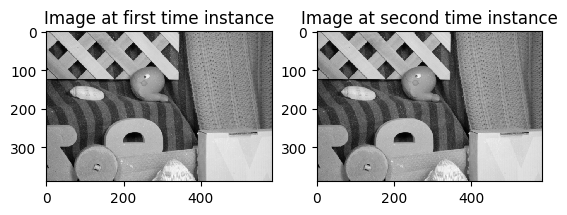

PyObject Text(0.5,1,'Image at second time instance')

In [13]:
# Problem 1: Optical Flow



  # Parameters, smoothing
  smooth_sigma = 2.0  # std
  smooth_fsize = 25   # window size

  # Parameters, coefficients
  coeff_sigma = 2.0  # std
  coeff_fsize = 11   # window size

  # Parameters, Harris keypoint detection
  harris_sigma = 1.0  # std
  harris_fsize = 15   # window size
  harris_threshold = 1e-7

  # Ignore locations to close to image boundaries
  boundary = 11

  # Load the images:
  im1 = Float64.(imread("frame09.png"))
  im2 = Float64.(imread("frame10.png"))
  figure()
  subplot(121)
  imshow(im1,"gray")
  title("Image at first time instance")
  subplot(122)
  imshow(im2,"gray")
  title("Image at second time instance")




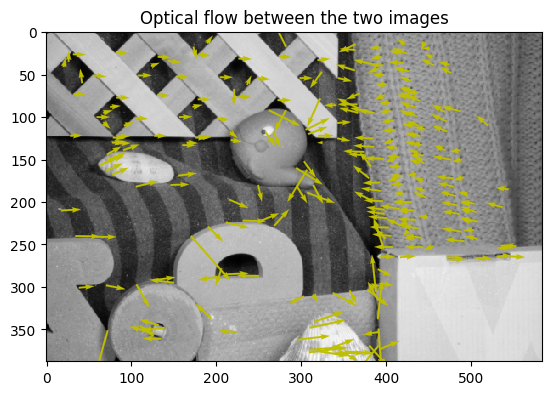

PyObject Text(0.5,1,'Optical flow between the two images')

In [15]:

  # Detect interest points using 'detect_interestpoints'
  px, py = Common.detect_interestpoints(im1,harris_sigma,harris_fsize,harris_threshold,boundary)

  # Presmooth images
  im1s = presmooth(im1, smooth_sigma, smooth_fsize)
  im2s = presmooth(im2, smooth_sigma, smooth_fsize)

  # First-order derivatives of smoothed images
  dx, dy, dt = compute_derivatives(im1s, im2s)

  # Coefficients of the linear system of equations
  dx2, dy2, dxdy, dxdt, dydt = compute_coefficients(dx, dy, dt, coeff_sigma, coeff_fsize)

  # Compute optical flow ONLY AT interest points
  u,v = compute_flow(px, py, dx2, dy2, dxdy, dxdt, dydt)

  # Show optical flow on top of first image
  show_flow(px,py,u,v,im1)
  title("Optical flow between the two images")

